In [1]:
import itertools
import gc
import numpy as np
import pandas as pd
import pandas_summary as pds
import seaborn as sns
import xgboost as xgb
import random
from IPython.display import HTML

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# pull in property data

props = pd.read_csv('zillow/properties_2016.csv')
train = pd.read_csv('zillow/train_2016_v2.csv')
sample = pd.read_csv('zillow/sample_submission.csv')

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
def xgb_train(X, y):
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

    print('Building DMatrix...')

    d_train = xgb.DMatrix(x_train, label=y_train)
    d_valid = xgb.DMatrix(x_valid, label=y_valid)

    #del x_train, x_valid; gc.collect()

    print('Training ...')

    params = {}
    params['eta'] = 0.02
    params['objective'] = 'reg:linear'
    params['eval_metric'] = 'mae'
    params['max_depth'] = 4
    params['silent'] = 1

    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=10)
    
    #del d_train, d_valid; gc_collect()
    
    return clf

def xgb_predict(clf, train_columns):
    print('Building test set ...')

    sample['parcelid'] = sample['ParcelId']
    df_test = sample.merge(props, on='parcelid', how='left')

    x_test = df_test[train_columns]
    for c in x_test.dtypes[x_test.dtypes == object].index.values:
        x_test[c] = (x_test[c] == True)

    #del df_test, sample; gc.collect()

    d_test = xgb.DMatrix(x_test)

    #del x_test; gc.collect()

    print('Predicting on test ...')

    p_test = clf.predict(d_test)

    # del d_test; gc.collect()

    sub = pd.read_csv('zillow/sample_submission.csv')
    for c in sub.columns[sub.columns != 'ParcelId']:
        sub[c] = p_test

    print('Writing csv ...')
    sub.to_csv('zillow/xgb_starter.csv', index=False, float_format='%.4f') # Thanks to @inversion

In [10]:
df_train = train.merge(props, how='left', on='parcelid')

X = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y = df_train['logerror'].values
print(X.shape, y.shape)

for c in X.dtypes[X.dtypes == object].index.values:
    X[c] = (X[c] == True)

clf = xgb_train(X, y)

(90275, 55) (90275,)
Building DMatrix...
Training ...
[0]	train-mae:0.486939	valid-mae:0.490393
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 100 rounds.
[10]	train-mae:0.401204	valid-mae:0.404618
[20]	train-mae:0.331746	valid-mae:0.335205
[30]	train-mae:0.275662	valid-mae:0.279161
[40]	train-mae:0.230542	valid-mae:0.233978
[50]	train-mae:0.194363	valid-mae:0.197653
[60]	train-mae:0.165497	valid-mae:0.168628
[70]	train-mae:0.142557	valid-mae:0.145508
[80]	train-mae:0.124477	valid-mae:0.12725
[90]	train-mae:0.110349	valid-mae:0.11298
[100]	train-mae:0.099421	valid-mae:0.101972
[110]	train-mae:0.091073	valid-mae:0.093566
[120]	train-mae:0.084774	valid-mae:0.08726
[130]	train-mae:0.080087	valid-mae:0.082575
[140]	train-mae:0.076652	valid-mae:0.079184
[150]	train-mae:0.074143	valid-mae:0.076725
[160]	train-mae:0.072323	valid-mae:0.074912
[170]	train-mae:0.070988	valid-mae:0.073593
[180]	train-mae:0.07003	

In [11]:
xgb_predict(clf, X.columns)

Building test set ...


/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Predicting on test ...
Writing csv ...


In [ ]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
summarize(train)
train.head()

In [3]:
# generator function for pulling out items a number at a time
def batch(s, n):
    for i in range(0, len(s), n):
        yield s[i:min(i+n, len(s))]
        
# test function
# display(props.columns)
# [c for c in batch(props.columns, 6)]

In [4]:
# for describing the data with DataFrameSummary
def summarize(df):
    for cols in batch(df.columns, 5):
        display(pds.DataFrameSummary(df[cols]).summary())
        
# test function
# describe(props)

In [8]:
def describe_values(df):
    stats = pd.DataFrame(columns=['column', 'dtype', 'sample', 'unique len', 'missing %'])
    for c in df.columns:
        stats.loc[-1] = [c, df[c].dtype, df[c].unique()[:3], len(df[c].unique()), int(df[c].isnull().sum(axis=0) / df[c].size * 100)]
        stats.index += 1
    display(stats.set_index('column'))

describe_values(props)

,dtype,sample,unique len,missing %
column,,,,
parcelid,int64,"[10754147, 10759547, 10843547]",2985217,0
airconditioningtypeid,float64,"[nan, 1.0, 13.0]",8,72
architecturalstyletypeid,float64,"[nan, 7.0, 21.0]",9,99
basementsqft,float64,"[nan, 216.0, 555.0]",752,99
bathroomcnt,float64,"[0.0, 2.0, 4.0]",38,0
bedroomcnt,float64,"[0.0, 4.0, 5.0]",22,0
buildingclasstypeid,float64,"[nan, 3.0, 4.0]",6,99
buildingqualitytypeid,float64,"[nan, 7.0, 4.0]",13,35
calculatedbathnbr,float64,"[nan, 2.0, 4.0]",35,4


In [28]:
clean = pd.DataFrame()
def pad(col, val=None, dtype=None):
    display(col)
    if col not in clean.columns: 
        clean[col] = props[col]
    display(clean[col].unique())
    if val != None:
        clean[col] = clean[col].fillna(val)
    if dtype != None:
        clean[col] = clean[col].astype(dtype)
    display(clean[col].unique())

In [57]:
pad('airconditioningtypeid', 0, 'category')

'airconditioningtypeid'

array([ nan,   1.,  13.,   5.,  11.,   9.,  12.,   3.])

array([  0.,   1.,  13.,   5.,  11.,   9.,  12.,   3.])

In [58]:
pad('architecturalstyletypeid', 0, 'category')

'architecturalstyletypeid'

array([ nan,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])

array([  0.,   7.,  21.,   8.,   2.,   3.,   5.,  10.,  27.])

In [60]:
pad('basementsqft', 0, 'int64')

'basementsqft'

array([   nan,   216.,   555.,   224.,   782.,   651.,   516.,   600.,
         732.,  1145.,   220.,   420.,   688.,   144.,   540.,  1312.,
         690.,   640.,   550.,    63.,   198.,  1120.,   924.,  1572.,
        1035.,   195.,   544.,   498.,   176.,   360.,   154.,   240.,
         616.,  1131.,   200.,  1016.,  1089.,  2443.,   276.,   396.,
         149.,   168.,   495.,   208.,   560.,   939.,   704.,   460.,
        1152.,   462.,  1904.,   888.,   170.,   625.,   450.,    72.,
         252.,   637.,    96.,  1172.,  1464.,   787.,   501.,   473.,
         318.,   112.,   394.,   985.,   169.,   400.,   826.,   780.,
        1350.,   610.,  1528.,   255.,   164.,   315.,   836.,   630.,
         160.,  1508.,   775.,   676.,   448.,   756.,   912.,   179.,
         700.,   348.,   595.,   231.,   100.,   266.,   620.,   757.,
         786.,   872.,   672.,   831.,  1544.,   946.,   180.,   313.,
         314.,   440.,   528.,    36.,   320.,   515.,   196.,   119.,
      

array([   0,  216,  555,  224,  782,  651,  516,  600,  732, 1145,  220,
        420,  688,  144,  540, 1312,  690,  640,  550,   63,  198, 1120,
        924, 1572, 1035,  195,  544,  498,  176,  360,  154,  240,  616,
       1131,  200, 1016, 1089, 2443,  276,  396,  149,  168,  495,  208,
        560,  939,  704,  460, 1152,  462, 1904,  888,  170,  625,  450,
         72,  252,  637,   96, 1172, 1464,  787,  501,  473,  318,  112,
        394,  985,  169,  400,  826,  780, 1350,  610, 1528,  255,  164,
        315,  836,  630,  160, 1508,  775,  676,  448,  756,  912,  179,
        700,  348,  595,  231,  100,  266,  620,  757,  786,  872,  672,
        831, 1544,  946,  180,  313,  314,  440,  528,   36,  320,  515,
        196,  119, 3374,  606,  736,  678, 1282,  135,   64,  506,  414,
       1296, 1197, 1112,  814,  530,  165, 1314,  352,  282,  293,  805,
       2025,  990,  173,  841,  108,  140,  280,  853,  751,  150, 1226,
         25,  384, 1552,  689,  656,  795, 1560,  8

In [96]:
display(props['bathroomcnt'].median())
pad('bathroomcnt', props['bathroomcnt'].median(), 'float64')

2.0

'bathroomcnt'

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,    nan,  18.  ,  16.  ,   1.75,
        17.  ,  19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [97]:
display(props['bedroomcnt'].median())
pad('bedroomcnt', props['bedroomcnt'].median(), 'float64')

3.0

'bedroomcnt'

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  nan,  15.,  17.,  18.,  20.,  19.])

array([  0.,   4.,   5.,   2.,   3.,   1.,   6.,   7.,   8.,  12.,  11.,
         9.,  10.,  14.,  16.,  13.,  15.,  17.,  18.,  20.,  19.])

In [62]:
pad('buildingclasstypeid', 0, 'category')

'buildingclasstypeid'

array([ nan,   3.,   4.,   5.,   2.,   1.])

[0.0, 3.0, 4.0, 5.0, 2.0, 1.0]
Categories (6, float64): [0.0, 3.0, 4.0, 5.0, 2.0, 1.0]

In [64]:
pad('buildingqualitytypeid', 0, 'category')

'buildingqualitytypeid'

array([ nan,   7.,   4.,  10.,   1.,  12.,   8.,   3.,   6.,   9.,   5.,
        11.,   2.])

[0.0, 7.0, 4.0, 10.0, 1.0, ..., 6.0, 9.0, 5.0, 11.0, 2.0]
Length: 13
Categories (13, float64): [0.0, 7.0, 4.0, 10.0, ..., 9.0, 5.0, 11.0, 2.0]

In [95]:
pad('calculatedbathnbr', dtype='float64')

# if it doesn't have a value, we just get it from bathroomcnt
props[['calculatedbathnbr', 'bathroomcnt', 'bedroomcnt']]
clean.loc[clean['calculatedbathnbr'].isnull(), ('calculatedbathnbr')] = clean.loc[clean['calculatedbathnbr'].isnull(), ('bathroomcnt')]
display(clean['calculatedbathnbr'].unique())

'calculatedbathnbr'

array([  nan,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

array([  nan,   2. ,   4. ,   3. ,   1. ,   2.5,   3.5,   5. ,   1.5,
         4.5,   7.5,   5.5,   6. ,   7. ,  10. ,   8. ,   9. ,  12. ,
        11. ,   8.5,   6.5,  13. ,   9.5,  14. ,  20. ,  19.5,  15. ,
        10.5,  18. ,  16. ,  17. ,  19. ,  12.5,  11.5,  14.5])

array([  0.  ,   2.  ,   4.  ,   3.  ,   1.  ,   2.5 ,   3.5 ,   5.  ,
         1.5 ,   4.5 ,   7.5 ,   5.5 ,   6.  ,   7.  ,  10.  ,   8.  ,
         9.  ,  12.  ,  11.  ,   8.5 ,   6.5 ,  13.  ,   9.5 ,  14.  ,
        20.  ,  19.5 ,  15.  ,  10.5 ,  18.  ,  16.  ,   1.75,  17.  ,
        19.  ,   0.5 ,  12.5 ,  11.5 ,  14.5 ])

In [94]:
pad('decktypeid', 0, 'category')

'decktypeid'

array([ nan,  66.])

[0.0, 66.0]
Categories (2, float64): [0.0, 66.0]

In [29]:
area_features = ['lotsizesquarefeet', 
                 'finishedsquarefeet6', 
                 'finishedsquarefeet15', 
                 'finishedsquarefeet13', 
                 'calculatedfinishedsquarefeet', 
                 'finishedsquarefeet12', 
                 'finishedfloor1squarefeet',
                 'finishedsquarefeet50',
                ]

area_features.reverse()

def fill_null(col1, col2):
#     display("{} <== {}".format(col1, col2))
    clean.loc[clean[col1].isnull(), (col1)] = clean.loc[clean[col1].isnull(), (col2)]

for col in area_features:
    clean[col] = props[col]

describe_values(clean.loc[:, area_features])
    
for col1, col2 in itertools.permutations(area_features, 2):
    fill_null(col1, col2)
    
describe_values(clean.loc[:, area_features])

for col in area_features:
    pad(col, clean[col].mean(), 'float32')

describe_values(clean.loc[:, area_features])

,dtype,sample,unique len,missing %
column,,,,
finishedsquarefeet50,float64,"[nan, 4969.0, 1080.0]",4803,93
finishedfloor1squarefeet,float64,"[nan, 4969.0, 1080.0]",4605,93
finishedsquarefeet12,float64,"[nan, 4000.0, 3633.0]",10671,9
calculatedfinishedsquarefeet,float64,"[nan, 73026.0, 5068.0]",12588,1
finishedsquarefeet13,float64,"[nan, 1440.0, 1368.0]",251,99
finishedsquarefeet15,float64,"[nan, 73026.0, 5068.0]",8817,93
finishedsquarefeet6,float64,"[nan, 15341.0, 1863.0]",4252,99
lotsizesquarefeet,float64,"[85768.0, 4083.0, 63085.0]",69954,9


,dtype,sample,unique len,missing %
column,,,,
finishedsquarefeet50,float64,"[85768.0, 4083.0, 73026.0]",17041,1
finishedfloor1squarefeet,float64,"[85768.0, 4083.0, 73026.0]",17030,1
finishedsquarefeet12,float64,"[85768.0, 4083.0, 73026.0]",17036,1
calculatedfinishedsquarefeet,float64,"[85768.0, 4083.0, 73026.0]",17036,1
finishedsquarefeet13,float64,"[85768.0, 4083.0, 73026.0]",17041,1
finishedsquarefeet15,float64,"[85768.0, 4083.0, 73026.0]",17041,1
finishedsquarefeet6,float64,"[85768.0, 4083.0, 73026.0]",17041,1
lotsizesquarefeet,float64,"[85768.0, 4083.0, 63085.0]",70185,1


'finishedsquarefeet50'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedfloor1squarefeet'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet12'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'calculatedfinishedsquarefeet'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet13'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet15'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'finishedsquarefeet6'

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

array([ 85768.,   4083.,  73026., ...,  10836.,  41801.,  33803.])

'lotsizesquarefeet'

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

array([  8.57680000e+04,   4.08300000e+03,   6.30850000e+04, ...,
         4.18010000e+04,   6.97900000e+04,   7.03415300e+06])

,dtype,sample,unique len,missing %
column,,,,
finishedsquarefeet50,float32,"[85768.0, 4083.0, 73026.0]",17041,0
finishedfloor1squarefeet,float32,"[85768.0, 4083.0, 73026.0]",17030,0
finishedsquarefeet12,float32,"[85768.0, 4083.0, 73026.0]",17036,0
calculatedfinishedsquarefeet,float32,"[85768.0, 4083.0, 73026.0]",17036,0
finishedsquarefeet13,float32,"[85768.0, 4083.0, 73026.0]",17041,0
finishedsquarefeet15,float32,"[85768.0, 4083.0, 73026.0]",17041,0
finishedsquarefeet6,float32,"[85768.0, 4083.0, 73026.0]",17041,0
lotsizesquarefeet,float32,"[85768.0, 4083.0, 63085.0]",70185,0


In [43]:
props.loc[props.rawcensustractandblock.isnull() & ~props.censustractandblock.isnull(), ['rawcensustractandblock', 'censustractandblock', 'fips']]

,rawcensustractandblock,censustractandblock,fips


In [37]:
col = 'yearbuilt'
np.sort(clean[col].unique())

array([ 1801.,  1805.,  1806.,  1807.,  1808.,  1810.,  1812.,  1815.,
        1819.,  1821.,  1823.,  1824.,  1825.,  1827.,  1828.,  1829.,
        1831.,  1833.,  1834.,  1840.,  1853.,  1855.,  1859.,  1862.,
        1865.,  1870.,  1874.,  1875.,  1876.,  1877.,  1878.,  1879.,
        1880.,  1881.,  1882.,  1883.,  1884.,  1885.,  1886.,  1887.,
        1888.,  1889.,  1890.,  1891.,  1892.,  1893.,  1894.,  1895.,
        1896.,  1897.,  1898.,  1899.,  1900.,  1901.,  1902.,  1903.,
        1904.,  1905.,  1906.,  1907.,  1908.,  1909.,  1910.,  1911.,
        1912.,  1913.,  1914.,  1915.,  1916.,  1917.,  1918.,  1919.,
        1920.,  1921.,  1922.,  1923.,  1924.,  1925.,  1926.,  1927.,
        1928.,  1929.,  1930.,  1931.,  1932.,  1933.,  1934.,  1935.,
        1936.,  1937.,  1938.,  1939.,  1940.,  1941.,  1942.,  1943.,
        1944.,  1945.,  1946.,  1947.,  1948.,  1949.,  1950.,  1951.,
        1952.,  1953.,  1954.,  1955.,  1956.,  1957.,  1958.,  1959.,
      

In [252]:
# investigate yearbuilt

#df = props[['structuretaxvaluedollarcnt', 'yearbuilt']].dropna()
#df.plot.scatter(x='yearbuilt', y='structuretaxvaluedollarcnt')

In [254]:
# utility function for splitting the date into components

def split_date(df, datecol):
    df[datecol+'_year'] = df[datecol].dt.year
    df[datecol+'_month'] = df[datecol].dt.month
    df[datecol+'_week'] = df[datecol].dt.week
    df[datecol+'_day'] = df[datecol].dt.day
    df[datecol+'_dayofweek'] = df[datecol].dt.dayofweek
    return df

split_date(train, 'transactiondate')
train.head()

,parcelid,logerror,transactiondate,transactiondate_year,transactiondate_month,transactiondate_week,transactiondate_day,transactiondate_dayofweek
0,11016594,0.0276,2016-01-01,2016,1,53,1,4
1,14366692,-0.1684,2016-01-01,2016,1,53,1,4
2,12098116,-0.0040,2016-01-01,2016,1,53,1,4
3,12643413,0.0218,2016-01-02,2016,1,53,2,5
4,14432541,-0.0050,2016-01-02,2016,1,53,2,5


In [255]:
# merge the property data into the training data

merged = train.merge(props, how='left', on='parcelid', copy=True)
# describe(merged)

In [259]:
# fill in yearbuilt NaNs with the mean because we're going to do some calculations with it

merged['yearbuilt'] = merged['yearbuilt'].astype(np.float32)
merged['yearbuilt'] = merged['yearbuilt'].fillna(2016)
merged['yearbuilt'] = merged['yearbuilt'].astype(np.int64)
merged['yearbuilt'].isnull().values.any()

False

In [260]:
# calculate the age of the property

merged['age'] = (merged['transactiondate_year'] - merged['yearbuilt']) * 12 + merged['transactiondate_month']
merged['age'].describe()

count    90275.000000
mean       570.685295
std        288.703091
min          1.000000
25%        354.000000
50%        556.000000
75%        763.000000
max       1579.000000
Name: age, dtype: float64

In [261]:
# categorical columns
cat_cols = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
            'decktypeid', 'fips', 'hashottuborspa', 'heatingorsystemtypeid', 'pooltypeid10', 
            'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 
            'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
            'regionidzip', 'storytypeid', 'typeconstructiontypeid', 'fireplaceflag', 'assessmentyear', 
            'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'yearbuilt']

# stuff splitting the date
cat_cols.extend(['transactiondate_day', 'transactiondate_dayofweek', 'transactiondate_month', 
                 'transactiondate_week', 'transactiondate_year'])

# columns we'll drop
drop_cols = ['transactiondate', 'parcelid', 'logerror']

# continuous columns
cont_cols = set(merged.columns) - set(cat_cols) - set(drop_cols)

display(cont_cols)

{'age',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'landtaxvaluedollarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'taxvaluedollarcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26'}

In [262]:
for c in cat_cols:
    merged[c] = merged[c].astype('str')
    merged[c].fillna("")
    merged[c] = merged[c].astype('category')
for c in cont_cols: 
    merged.loc[merged[c].isnull(), c] = 0
    
#describe(merged)

In [263]:
#see if all properties have test data
subm = pd.read_csv('zillow/sample_submission.csv')

# describe(subm)

In [264]:
# see how much training data we have

# total props in submission
display(subm['ParcelId'].count())

# submission vs property data
display(subm[~subm['ParcelId'].isin(props['parcelid'])]['ParcelId'].count())

# submission vs training data
display(subm[~subm['ParcelId'].isin(train['parcelid'])]['ParcelId'].count())

2985217

0

2895067

In [265]:
X = merged.drop(drop_cols, axis=1)
X = merged.drop('logerror', axis=1)
y = merged['logerror']

In [266]:
cat_maps = [(c, LabelEncoder()) for c in cat_cols]
cont_maps = [([c], StandardScaler()) for c in cont_cols]

In [267]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(X)
len(cat_map_fit.features)

32

In [268]:
cont_mapper = DataFrameMapper(cont_maps)
cont_map_fit = cont_mapper.fit(X)
len(cont_map_fit.features)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


31

In [269]:
X_cat = cat_mapper.transform(X).astype(np.int64)
X_cont = cont_mapper.transform(X).astype(np.float32)

/home/terence/anaconda2/envs/deeplearn/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [270]:
X_all = np.concatenate([X_cat, X_cont], axis=1)

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.1)

In [272]:
train = xgboost.DMatrix(X_train, y_train, feature_names=cat_cols + list(cont_cols))
test = xgboost.DMatrix(X_test, y_test, feature_names=cat_cols + list(cont_cols))

In [285]:
xgb_parms = {'eta': 0.01, 'max_depth': 6, 'objective': 'reg:linear', 'eval_metric': 'mae', 'silent': 1}

In [286]:
xgb_parms['seed'] = random.randint(0,1e9)
watchlist = [(train, 'train'), (test, 'test')]
xgbmodel = xgboost.train(xgb_parms, train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=50)

[0]	train-mae:0.492253	test-mae:0.490514
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 100 rounds.
[50]	train-mae:0.306081	test-mae:0.304423
[100]	train-mae:0.196957	test-mae:0.195456
[150]	train-mae:0.134524	test-mae:0.133135
[200]	train-mae:0.100185	test-mae:0.098941
[250]	train-mae:0.082543	test-mae:0.081343
[300]	train-mae:0.074129	test-mae:0.073052
[350]	train-mae:0.070293	test-mae:0.069268
[400]	train-mae:0.068527	test-mae:0.067582
[450]	train-mae:0.067659	test-mae:0.066816
[500]	train-mae:0.067184	test-mae:0.066461
[550]	train-mae:0.066905	test-mae:0.066294
[600]	train-mae:0.06671	test-mae:0.066228
[650]	train-mae:0.066561	test-mae:0.066205
[700]	train-mae:0.066428	test-mae:0.066199
[750]	train-mae:0.066313	test-mae:0.066208
[800]	train-mae:0.066198	test-mae:0.066253
Stopping. Best iteration:
[732]	train-mae:0.066353	test-mae:0.066193



In [287]:
xgbmodel.eval(test)

b'[0]\teval-mae:0.066267'

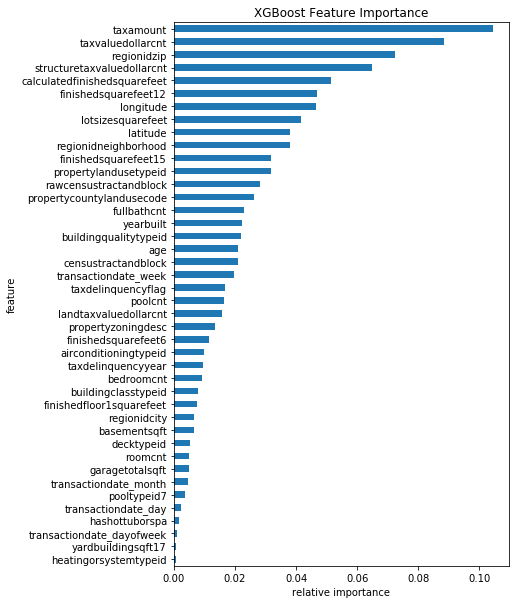

In [276]:
importance = xgbmodel.get_fscore()
importance = sorted(importance.items(), key=lambda x: x[1])

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');